## Section 2: 

Récupération de la donnée: 


``` bash
    curl -X GET https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/refs/heads/main/causal-inference-in-python/data/cross_sell_email.csv > cross_sell_email.csv
```

source: https://github.com/matheusfacure/causal-inference-in-python-code/tree/main/causal-inference-in-python/data


In [1]:
import pandas as pd
import numpy as np

data_sell = pd.read_csv("./data/cross_sell_email.csv")
data_sell

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0
...,...,...,...,...
318,0,long,18,0
319,1,no_email,16,0
320,0,no_email,15,0
321,1,no_email,16,0


In [2]:
mean = data_sell.groupby("cross_sell_email").mean()
mean

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


Comme nous pouvons le voir il y a deux modalités (le groupe neutre ne comptant pas comme ne modalité).

Ici nous obtenons les scores de: 

- 4 % pour le groupe controle, soit $ E[Y|T=0] $, 
- 5 % pour l'envoie d'email long, soit $ E[Y|T=1] $,
- 12 % pour l'envoie d'email court, soit $ E[Y|T=2] $


Egalement côté, similarité des groupes, la randomisation a mal été faite coté gender où les différences entre H/F sont plus forte dans short avec 63% d'homme (car homme = 1 dans la colonne gender), hors dans les autres nous avons env. 55% d'homme ce qui équilibre davantage les groupes. 

Coté age, les groupes sembles similaires ce qui ne soulève pas de problème à première vue.


In [3]:
mean["ATE"] = mean.conversion - mean.loc["no_email", "conversion"]
print(mean[["conversion", "ATE"]].to_string(formatters={"ATE": "{:,.2f}".format, "conversion": "{:,.2f}".format}))

                 conversion  ATE
cross_sell_email                
long                   0.06 0.01
no_email               0.04 0.00
short                  0.12 0.08


L'ATE est de:
 
- 1 % pour l'envoie d'email long, soit $ E[Y|T=1] - E[Y|T=0] $,
- 8 % pour l'envoie d'email court, soit $ E[Y|T=2] - E[Y|T=0] $

=> Page 35

In [4]:
X = ["gender", "age"]

mu = data_sell.groupby("cross_sell_email")[X].mean()
var = data_sell.groupby("cross_sell_email")[X].var()

norm_diff = ((mu - mu.loc["no_email"])/np.sqrt((var + var.loc["no_email"])/2))
norm_diff

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


Pour vérfier si la différence est forte, il verifier la différence normalisé:

$$ 
    \frac{ \hat{\mu}_{tr} - \hat{\mu}_{co} } { \sqrt{ (\hat{\sigma}_{tr}^{2} - \hat{\sigma}_{co}^{2})/2 } }
$$

Où:
- tr = traitement donc t=i
- co = controle donc t=0


Ici on remarque que les modalités conjointes short\gender ont normale différentielle forte qui montre un ecart fort entre les deux autres groupe (t=0 et t=long).
C'est aussi le cas pour le groupe long\age.

=> page 36

**Conclusion:**   
Bref, ces dernières ont servis pour montrer le "randomized controlled trials" (RCT), s'il est mal fait nos résultats montre une différence mais qui peut etre induit par un biais et non le traitement. En locurence ici, les hommes peuvent avoir plus tendance à consommer que les femmes ce qui fait que le taux de réussite peut etre plus important dans ce dernier (email court) que dans les autres modalités.


Parfois pour des raisons éthiques, budgetaire ou autre, le RCT n'est pas possible ainsi nous passons à l'échantillon observé qui peut contenir des biais dans nos données.

---

## Partie 2: Que faire quand on a pas de randomisation

``` bash
    curl -X GET https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/refs/heads/main/causal-inference-in-python/data/enem_scores.csv > ./data/enem_scores.csv
```

### **Les équations dangeureuses**

Il existe deux types d'équations dangueureuse: 
1. Si on connait ces équations, elles sont dangeureuses (la masse critique pour faire un explosif),
2. Si on connait mal/pas ces equations, cela est dangeureux (exemple équation de Moivre: $ SE =  \frac{\sigma}{\sqrt{n}} $) 


**Verifions pourquoi cette équation est dangeureuse ?**

In [5]:
df = pd.read_csv("./data/enem_scores.csv")

df.sort_values("avg_score", ascending=False).head(10) 

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


/tmp/ipykernel_27749/3405166342.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x=[df_other, df_max], labels=["df_other", "df_max"])


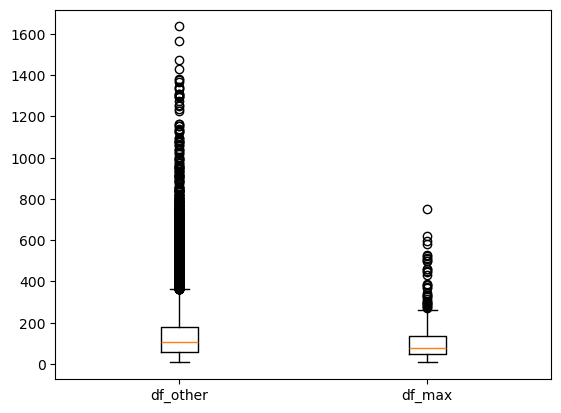

In [6]:
import matplotlib.pyplot as plt

df["cat"] = pd.qcut( df["avg_score"], q=100)
df["cat"].cat.categories.min()

df_max = df[df["cat"] == df["cat"].cat.categories.max()].number_of_students
df_other = df[df["cat"] != df["cat"].cat.categories.max()].number_of_students

plt.boxplot(x=[df_other, df_max], labels=["df_other", "df_max"])
plt.show()

Si on a analyse seulement, les ecoles avec les meilleurs réussites on peut voir que moins il y a d'élèves, plus les élèves sont doués. On a par exemple ici le 1% des ecoles les mieux classés en terme d'examens contre les 99% autre restants.

Pourquoi il y a une erreurs dans ce raisonnement. En effet, pourquoi ne pas verifier que les 1 % les moins bons peuvent etre différents. 

Comme vous pouvez le voir, le résultat est directement orienté sur l'hypothèse populaire: "Moins il y a d'élève mieux sont les résultats", hors cela peut etre un biais de confirmation qui peut influencer notre étude.

/tmp/ipykernel_27749/2123125345.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x=[df_min, df_other, df_max], labels=["df_min", "df_other", "df_max"])


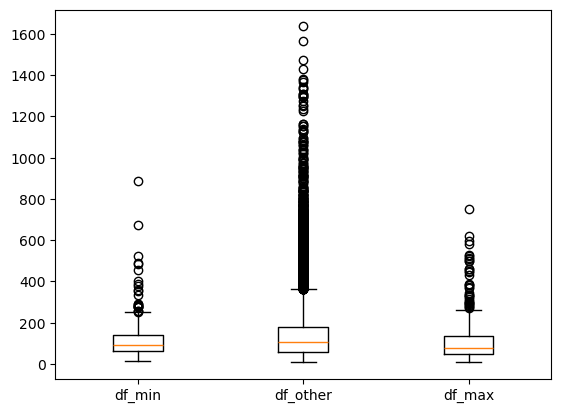

In [7]:
df_min = df[df["cat"] == df["cat"].cat.categories.min()].number_of_students

plt.boxplot(x=[df_min, df_other, df_max], labels=["df_min", "df_other", "df_max"])
plt.show()

Comme vous pouvez le voir on tombe sur un tous autre résultat. Les petits établissements peuvent avoir aussi des très mauvais résultat. 

**Alors pourquoi ?**

C'est l'effet de l'aléatoire, plus il y a l'élèves plus on tends à une moyenne, au contraire les petits établissements sont sujets à des décalages bénéfiques ou non, donc il peut y avoir une surpopulation de bon ou de mauvais élèves à comparer des autres grands échantillons.

Si on reprend la formule de Moivre qui estime l'incertitude: $ SE =  \frac{\sigma}{\sqrt{n}} $

On peux voir clairement que plus il y a d'élèves dans un établissement, plus il converge vers un point (la moyenne). 

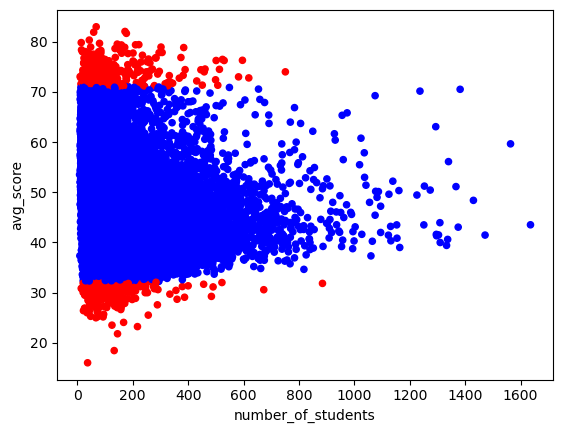

In [8]:
idx_is_not_99 = df["cat"].isin([df["cat"].cat.categories.min(), df["cat"].cat.categories.max()])
df.plot.scatter(x="number_of_students", y="avg_score", c=["r" if s else "b" for s in idx_is_not_99.to_list()])
plt.show()

## Reprise de l'étude de l'A/B testing

In [9]:
get_data = lambda name: data_sell.query(f"cross_sell_email=='{name}'")["conversion"]

short_email = get_data("short")
long_email = get_data("long")
no_email = get_data("no_email")
email = data_sell.query(f"cross_sell_email!='no_email'")["conversion"]


size_group = data_sell.groupby("cross_sell_email").size()

In [10]:
def se(y:pd.Series):
    return y.std() / np.sqrt(len(y))

print("Erreur standart du groupe email long:", round(se(long_email), 2), "et version pandas:", round(long_email.sem(), 2))
print("Erreur standart du groupe email court:", round(se(short_email), 2), "et version pandas:", round(short_email.sem(), 2))

Erreur standart du groupe email long: 0.02 et version pandas: 0.02
Erreur standart du groupe email court: 0.03 et version pandas: 0.03


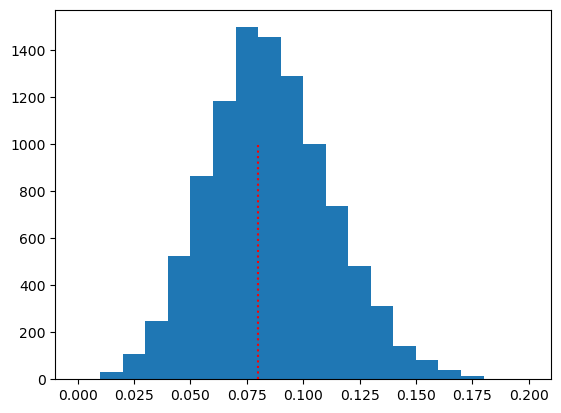

In [11]:
get_bernouilli = lambda: np.random.binomial(1, 0.08, 100)

np.random.seed(42)

exps = [get_bernouilli().mean() for _ in range(10000)]

plt.hist(exps, bins=20)
plt.vlines(0.08, ymax=1000, ymin=0, colors="r", linestyles='dotted')

Comment on peut le voir, nous avons l'utilisation du théorème centrale limite. 

Le but étant de trouver le moyenne des moyennes. Selon le livre, la moyenne des données est toujours normalement distribué. 

In [12]:
exp_se = short_email.sem()
exp_mu = short_email.mean()
for nb_sigma in [1, 2]:
    print("\nPour ",nb_sigma, " Sigma on a:")

    ci = (round(exp_mu - nb_sigma* exp_se, 2), round(exp_mu + nb_sigma* exp_se, 2))

    print("L'intervale de confience du mu de notre expérience est:", ci) 


Pour  1  Sigma on a:
L'intervale de confience du mu de notre expérience est: (0.09, 0.16)

Pour  2  Sigma on a:
L'intervale de confience du mu de notre expérience est: (0.06, 0.19)


Ou en fonction de alpha, la formule (ppf) récupère l'inverse de la fonction cumulative de la loi normale. 

In [13]:
from scipy import stats

for alpha in [0.99, 0.95, 0.90]:
    interval_sigma = np.abs(stats.norm.ppf((1-alpha)/2))
    print("\nPour un intervale à ",alpha, "% on as", round(interval_sigma, 2))

    ci = (round(exp_mu - interval_sigma* exp_se, 4), round(exp_mu + interval_sigma* exp_se, 4))
    print("L'intervale de confience du mu de notre expérience est:", ci) 


Pour un intervale à  0.99 % on as 2.58
L'intervale de confience du mu de notre expérience est: (0.0469, 0.2031)

Pour un intervale à  0.95 % on as 1.96
L'intervale de confience du mu de notre expérience est: (0.0656, 0.1844)

Pour un intervale à  0.9 % on as 1.64
L'intervale de confience du mu de notre expérience est: (0.0751, 0.1749)


### Comparaison des intervale

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def show_graph_normal_law(data:pd.Series, color="g", name="no"):
    num_samples = 1000
    n = 50

    sample_means = [np.mean(np.random.choice(data, n)) for _ in range(num_samples)]
    mu = np.mean(sample_means)
    sigma = np.std(sample_means, ddof=1)
    ci_95 = 1.96 * (sigma / np.sqrt(n))

    x = np.linspace(min(sample_means), max(sample_means), 100)
    y = norm.pdf(x, mu, sigma)
    
    plt.plot(x, y, 'r-', lw=2, label=f"curve of {name}", c=color)
    plt.vlines(mu, ymin=0, ymax=norm.pdf([mu], mu, sigma)[0], colors=color)
    plt.fill_between(x, norm.pdf(x, mu, sigma), where=(x >= mu - ci_95) & (x <= mu + ci_95), 
                 color=color, alpha=0.3, label=f"IC 95% for {name}")
    plt.title("Estimation de la loi normale de l'estimateur de la moyenne avec IC 95%")
    plt.xlabel("Valeur moyenne des échantillons")
    plt.ylabel("Densité")


Pour un intervalle de confiance à 0.95, nous avons pour:
Pour le groupe short, on l'intervalle (0.07, 0.18)
Pour le groupe long, on l'intervalle (0.01, 0.1)
Pour le groupe no_email, on l'intervalle (0.0, 0.08)


/tmp/ipykernel_27749/3237068836.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, y, 'r-', lw=2, label=f"curve of {name}", c=color)


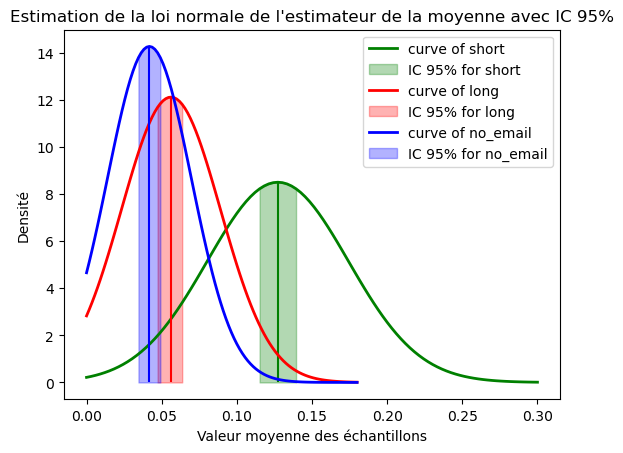

In [15]:
alpha = 0.95
get_ci = lambda y, nb_sigma:  (round(y.mean() - nb_sigma* y.sem(), 2), round(y.mean() + nb_sigma* y.sem(), 2))
interval_sigma = np.abs(stats.norm.ppf((1-alpha)/2))

print(f"Pour un intervalle de confiance à {alpha}, nous avons pour:")

IC_long = get_ci(long_email, interval_sigma)
IC_short = get_ci(short_email, interval_sigma)
IC_no_email = get_ci(no_email, interval_sigma)

for name, IC, data, color, name in [
    ("short", IC_short, short_email, "g", "short"),
    ("long", IC_long, long_email, "r", "long"),
    ("no_email", IC_no_email, no_email, "b", "no_email"),
    ]:
    print(f"Pour le groupe {name}, on l'intervalle", IC)
    show_graph_normal_law(data, color=color, name=name)
    plt.legend()

Ici si nous voulons dire que short et long/no-email sont statistiquement idépendants, un premier indice est de voir si les courbes se chevauchent, ici c'est le cas, mais elle se chevauche de peu. Il faut donc faire un test pour attribuer si oui ou non, il y a indépendance.

Pour rappel, l'intervale de confiance ne contient pas la moyenne à 95% de chance mais plutot on fait confiance à ce calcul à une hauteur de 95% (nous sommes dans les statisques dites frequentiste). L'intervale en soie, peut ou non contenir la moyenne. Si nous voulons nous rapprocher du terme, la valeur est contenu avec 95 % chance, il faut utiliser les intervalles bayésiens appelée [intervalle de crédibilité](https://epirheum.com/ic-intervalle-de-credibilite-vs-intervalle-de-confiance-quelles-differences/).

/tmp/ipykernel_27749/670645584.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(n1, hist=False, label="$N(4, 3^2)$")
/tmp/ipykernel_27749/670645584.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(n2, hist=False, label="$N(4, 4^2)$")
/tmp/ipykernel_27749/670645584.py:13

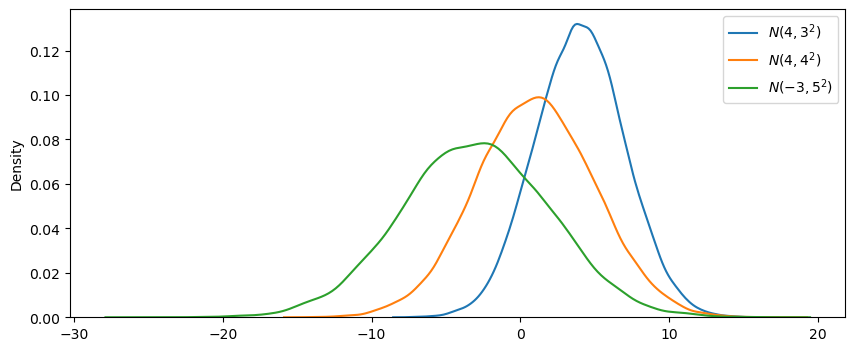

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt 

np.random.seed(123)

n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)

n_diff = n2 - n1
plt.figure(figsize=(10,4))
sns.distplot(n1, hist=False, label="$N(4, 3^2)$") 
sns.distplot(n2, hist=False, label="$N(4, 4^2)$") 
sns.distplot(n_diff, hist=False, label="$N(-3, 5^2)$") 
plt.legend()

In [17]:
diff_mu = short_email.mean() - no_email.mean()
diff_sem = np.sqrt(short_email.sem()**2 + no_email.sem()**2)
cov = np.cov(short_email[:min(short_email.shape[0], no_email.shape[0])], no_email[:min(short_email.shape[0], no_email.shape[0])])[0][1]

diff_std = np.sqrt(short_email.var() + no_email.var() + 2*cov) # + 2*np.cov(short_email, no_email) si non independante sinon proche de 0 comme c'est le cas ici...

ci = (diff_mu - 1.96*diff_sem, diff_mu + 1.96*diff_sem)
ci

(0.010239808474398426, 0.15465380854687816)

/tmp/ipykernel_27749/3547251203.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, y, 'r-', lw=2, label=f"curve of {name}", c=color)


Text(0, 0.5, 'Densité')

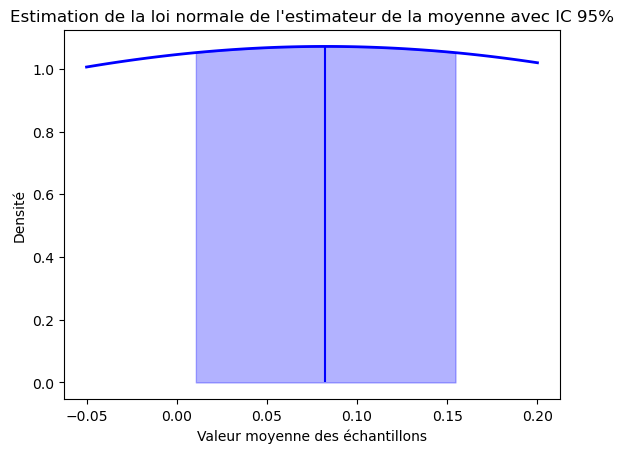

In [18]:
# sample_means=30000

mu = diff_mu
sigma = diff_std
ci_95 = 1.96 * diff_sem

x = np.linspace(-0.05, 0.2, 100)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'r-', lw=2, label=f"curve of {name}", c=color)
plt.vlines(mu, ymin=0, ymax=norm.pdf([mu], mu, sigma)[0], colors=color)
plt.fill_between(x, norm.pdf(x, mu, sigma), where=(x >= mu - ci_95) & (x <= mu + ci_95), 
                color=color, alpha=0.3, label=f"IC 95% for {name}")
plt.title("Estimation de la loi normale de l'estimateur de la moyenne avec IC 95%")
plt.xlabel("Valeur moyenne des échantillons")
plt.ylabel("Densité")


Nous pouvons formuler l'hypothèse suivante:  
$ H_0 : Conversion_{no-email} = Conversion_{short}  $

Ici la différence des lois normal nous montre que l'IC ne contient pas 0. Si ça avait été le cas, le 0 aurait été compris.
Hors ici nous pouvons dire qu'95% de confiance que la différence est significative. 

### Taux de conversion avec seuil:

Contexte: pour eviter d'etre perçus comme spam, il envoie un mail que si le taux de conversion est sup. à 1%.  
$ H_0 : Conversion_{no-email} + 0.01 = Conversion_{short}  $


In [19]:
diff_mu_1 = short_email.mean() - no_email.mean() -0.01
diff_sem_1 = np.sqrt(short_email.sem()**2 + no_email.sem()**2)
cov_1 = np.cov(short_email[:min(short_email.shape[0], no_email.shape[0])], no_email[:min(short_email.shape[0], no_email.shape[0])])[0][1]

diff_std_1 = np.sqrt(short_email.var() + no_email.var() + 2*cov) 

ci_1 = (diff_mu_1 - 1.96*diff_sem_1, diff_mu_1 + 1.96*diff_sem_1)
ci_1

(0.00023980847439843134, 0.14465380854687815)

On ne peut pas rejeter l'hypothèse $ H_0 $ car on est trop proche du 0 dans notre IC. 

### Test statistique lorsqu'on souhaite que mu soit équivalent à 0

Le but de ce test est de crée une statistique qui suit une loi normale. 
Si cette stats sort de l'IC à 95 % on peut rejeter l'hypothèse avec 95 % de confiance. 

Voici la statistique en question:

$$ 

t_{\Delta} = \frac{\mu_{\Delta} - H_0}{SE_{\Delta}} = \frac{(\mu_1 - \mu_2) - H_0}{\sqrt{\sigma^2_1/n_1 + \sigma^2_2/n_2}} 

$$

La partie $ \sqrt{\sigma^2_1/n_1 + \sigma^2_2/n_2} $ permet de reduire la stats pour une loi normale (0, 1).
Et on centre grâce à $ \mu_{\Delta} - H_0 $.

Exemple avec notre stats on souhaites que ça soit l'intervalle de 0 avec $ H_0 = 0 $

In [20]:
t_stat = (diff_mu - 0) / diff_sem
print("t_stat: ", t_stat)
print("p-value: ", (1 - stats.norm.cdf(t_stat))*2)

t_stat:  2.237951231871536
p-value:  0.025224235562152142


En reprennant la première différence on a que $ \mu $ est statistiquement différente de 0. De part que la stat ne se trouve pas dans l'IC à 95%.

Pour éviter de spécifier un niveau de confiance, on peut calcule la p-value. Ici, elle est de 0.025 soit 2.5 % de chance que notre valeur soit en dehors de l'intervale. En d'autre terme, 
un IC à 95 % permet de laisser 0 hors de porter mais à 99 % ce n'est pas le cas.

## La puissance de test: Comment établir n à l'avance 

Et ce pour chacun de nos groupes afin que le si H0 est fausse il soit rejeter correctement. 

On souhates faire un test statistique pour voir si la différence de nos deux groupes est différentes de 0 (soit notre H0).

Pour cela nous pouvons partir de notre formule de base:

$$ 
    IC_{95} =  {\mu - \alpha (~1.96) * SE; \mu + \alpha (~1.96) * SE}
$$

$$ 
    SE = \sigma / \sqrt{n} 
$$

où $ \mu = 0 $

Il faut que pour rejeter notre H0 que l'on soit sure à $ \beta $ % de ne pas avoir $ \mu $ dans l'intervalle.

Pour cela, on prend la borne précédente, comme on sait que c'est un intervalle à 95 % de confiance, on l'appel $ \delta $ donc $ \delta = \mu - \alpha (~1.96) * SE  $ 

Et par la force des statistiques $ \delta $ suit aussi une loi normale, on va lui attribuer un intervalle de confiance (à 80% par exemple), donc on dit qu'on a une puissance de test à 80 %, soit une valeur égale à 0.84.

On peut calculer sont IC également (on sait que l'estimateur $ \delta $ suit la meme loi normal celle précente seulement on l'a translater sur $ \delta $):

$$
    IC_{80} =  \delta + \beta * SE_{\Delta}
$$ 

où $ SE_{\Delta} $ est la différence entre les deux groupes (controle et traitement). 


$$
    SE_{\Delta} = \sqrt{ SE^2_1 + SE^2_2 } 
$$

Si on suppose que les deux groupes possède la meme variance nous avons:

$$
    SE_{\Delta} = \sqrt{ 2SE^2 } = \sqrt{ 2\sigma^2/n } = \sigma * \sqrt{ 2/n }
$$

On se retrouve enfin avec:

$$ 
    \delta = (\alpha + \Beta) * \sigma * \sqrt{ 2/n }
$$

Retournons pour n maintenant:

$$ 
    n = 2 * (\alpha + \Beta) * \sigma^2 / \delta
$$

avec $ \Beta + \alpha = 0.84 + 1.96 = 2.8 $

--- 

Pour finir si nous connaissons notre groupe controle déjà, nous pouvons l'utiliser pour calculer notre $ \sigma $ et ainsi trouver notre n

In [27]:
np.ceil(2 * 2.8**2 * no_email.std()**2 / 0.01 )

65.0

In [25]:
data_sell.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64